In [2]:
import h5py

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D,Conv2DTranspose


In [126]:
import pandas as pd
import tensorflow as tf

# Image size parameters
img_height, img_width = 128, 128
BATCH_SIZE = 2

# Define column names for the CSV files
columns = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']

# Read train and validation CSV files into DataFrames
train_df = pd.read_csv('table-detection-dataset/train.csv', names=columns)
val_df = pd.read_csv('table-detection-dataset/val.csv', names=columns)

# Decode image
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)  # Reading image as RGB
    img = tf.image.resize(img, [img_height, img_width])  # Resize to target size
    return img

def create_table_mask(image, bbox, img_width=img_width, img_height=img_height):
    table_mask = tf.zeros((1, img_height, img_width, 1), dtype=tf.float32)
    xmin, ymin, xmax, ymax = bbox
    
    # Convert to integers for indexing
    xmin = tf.cast(tf.math.floor(xmin), tf.int32)
    ymin = tf.cast(tf.math.floor(ymin), tf.int32)
    xmax = tf.cast(tf.math.ceil(xmax), tf.int32)
    ymax = tf.cast(tf.math.ceil(ymax), tf.int32)
    
    # Ensure coordinates are within bounds
    xmin = tf.maximum(0, xmin)
    ymin = tf.maximum(0, ymin)
    xmax = tf.minimum(img_width, xmax)
    ymax = tf.minimum(img_height, ymax)
    
    # Create a filled rectangle by setting all pixels in the region to 1.0
    indices = tf.reshape(tf.where(tf.ones((ymax-ymin, xmax-xmin))), [-1, 2])
    indices = indices + [ymin, xmin]
    updates = tf.ones(tf.shape(indices)[0])
    
    table_mask = tf.tensor_scatter_nd_update(
        tf.squeeze(table_mask),
        indices,
        updates
    )    
    return table_mask

def process_image_and_masks(file_path, annotations_df):
    image_name = tf.strings.split(file_path, '/')[-1]
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    def get_annotation(image_name):
        image_name = image_name.numpy().decode('utf-8')
        base_name = os.path.basename(image_name)
        
        annotation = train_df[train_df['filename'] == base_name]
        if not annotation.empty:
            # Get original bbox coordinates
            original_bbox = annotation[['xmin', 'ymin', 'xmax', 'ymax']].values[0]
            
            # Scale coordinates to match our resized image (128x128)
            # Assuming original images are all the same size, if not we need to get original size
            original_width = max(original_bbox[2], max(train_df['xmax']))  # Approximate from your bbox values
            original_height = max(original_bbox[3], max(train_df['ymax']))  # Approximate from your bbox values
            
            # Scale the coordinates
            scaled_bbox = [
                original_bbox[0] * img_width / original_width,   # xmin
                original_bbox[1] * img_height / original_height, # ymin
                original_bbox[2] * img_width / original_width,   # xmax
                original_bbox[3] * img_height / original_height  # ymax
            ]
            
            bbox = scaled_bbox
        else:
            print(f"No annotation found for {base_name}")
            bbox = [0, 0, 0, 0]
        
        return tf.convert_to_tensor(bbox, dtype=tf.float32)
    
    bbox = tf.py_function(get_annotation, [image_name], tf.float32)
    bbox.set_shape([4])
    
    table_mask = tf.py_function(
        lambda x, y: create_table_mask(x, y),
        [img, bbox],
        tf.float32
    )
    table_mask.set_shape([img_height, img_width])
    column_mask = create_column_mask()
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    table_mask = tf.cast(table_mask, tf.float32)
    column_mask = tf.cast(column_mask, tf.float32)
    return img, {"table_output": table_mask, "column_output": column_mask}

# Create column mask (empty, all zeros)
def create_column_mask(img_width=img_width, img_height=img_height):
    return tf.zeros((img_height, img_width), dtype=tf.float32)

In [127]:
import tensorflow as tf
import pandas as pd
import os
def process_csv_to_dataset(csv_df, image_dir):
    file_paths = [os.path.join(image_dir, filename) for filename in csv_df['filename']]
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(lambda file_path: process_image_and_masks(file_path, csv_df), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


In [163]:
image_dir = 'table-detection-dataset/images'  # Replace with the correct path to your images
tf.keras.backend.clear_session()
# Create train and validation datasets
train_dataset = process_csv_to_dataset(train_df, image_dir)
val_dataset = process_csv_to_dataset(val_df, image_dir)

In [129]:
'''train_dataset = train_dataset.cache()  # Cache the data
train_dataset = train_dataset.shuffle(buffer_size=1000)  # Shuffle with a good buffer
train_dataset = train_dataset.batch(BATCH_SIZE)  # Batch the data
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)'''


In [165]:
print(len(train_dataset))
    

209


In [166]:
print(len(val_dataset))

100


In [164]:
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [167]:
val_dataset=val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [168]:
for img, masks in train_dataset.take(1):  # Take the first batch
    print("Image shape:", img.shape)
    print("Table mask shape:", masks['table_output'].shape)
    print("Column mask shape:", masks['column_output'].shape)

Image shape: (2, 128, 128, 3)
Table mask shape: (2, 128, 128)
Column mask shape: (2, 128, 128)


Image shape: (2, 128, 128, 3)


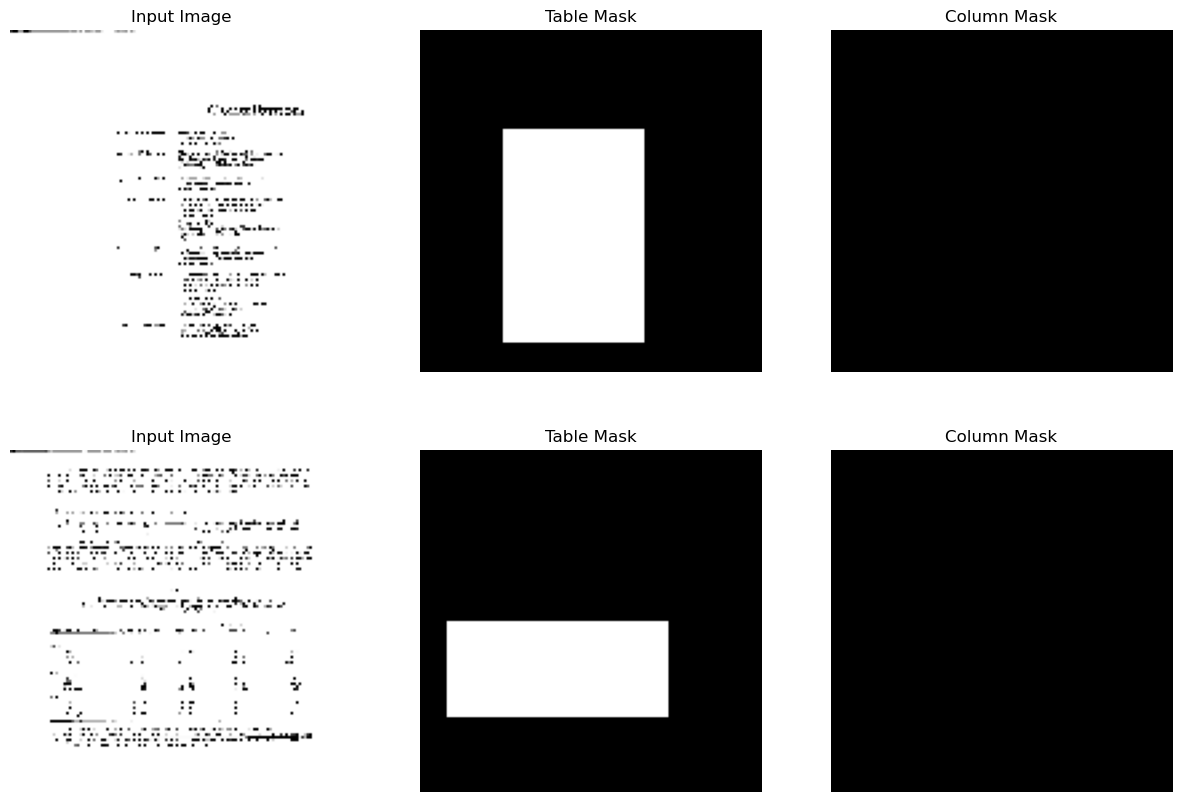

In [172]:
import matplotlib.pyplot as plt

def display(display_list):
    batch_size = display_list[0].shape[0]  # Get batch size
    plt.figure(figsize=(15, batch_size * 5))  # Adjust figure size
    
    for b in range(batch_size):  # Iterate over batch
        title = ['Input Image', 'Table Mask', 'Column Mask']
        
        for i in range(len(display_list)):
            plt.subplot(batch_size, len(display_list), b * len(display_list) + i + 1)
            plt.title(title[i])
            
            img = display_list[i][b]  # Take the `b`th image from batch
            if i == 0:  # Original image
                plt.imshow((img.numpy() * 255).astype("uint8"))
            else:  # Masks
                plt.imshow(img.numpy(), cmap='gray')

            plt.axis('off')
    
    plt.show()

# ✅ **Use the updated function**
for image, masks in train_dataset.take(1):
    print("Image shape:", image.shape)
    display([image, masks['table_output'], masks['column_output']])


In [144]:
from tensorflow.keras.models import load_model

# Load the saved model from the .keras file
model = load_model('stored_model/3/model_googlenet_new2.keras')


In [145]:
for layer in model.layers[:-3]:  # Freeze all but the last 3 layers
    layer.trainable = False

In [146]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 0.0001
    decay_rate = 0.96
    decay_steps = 10
    return initial_lr * decay_rate ** (epoch / decay_steps)
optimizer=Adam(learning_rate=0.001,beta_1=0.9, 
    beta_2=0.999)
lr_callback = LearningRateScheduler(lr_schedule)
loss_weights = {'table_output': 1.0, 'column_output': 1.0}

model.compile(optimizer=optimizer, 
              loss={'table_output': 'binary_crossentropy', 'column_output': 'binary_crossentropy'},
              loss_weights=loss_weights,
               metrics={'table_output': 'accuracy', 'column_output': 'accuracy'}
             )

In [159]:
tf.debugging.set_log_device_placement(True)
tf.keras.backend.clear_session()  # Clears previous sessions
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 100//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=209,
                          validation_data=val_dataset,
                          callbacks=[lr_callback])
model.save('stored_model/finetuned_g.keras')

Epoch 1/50


TypeError: 'NoneType' object is not callable

In [155]:
print(train_dataset)
print(val_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), {'table_output': TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None), 'column_output': TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None)})>
<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), {'table_output': TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None), 'column_output': TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None)})>


In [158]:
print(lr_callback)
print(BATCH_SIZE)

2
